In [1]:
import shap
import lime
from shap import TreeExplainer
from lime.lime_tabular import LimeTabularExplainer
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib as plt
from joblib import load
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from joblib import load

c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rf_model = load("C:/Users/zen/Documents/-- four/s2/FYP I/XAl-on-healthcare-diagnostics/version_3.0/ml-xai/random_forest_model.pkl")

c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\zen\Documents\-- four\s2\FYP I\XAl-on-healthcare-diagnostics\xai\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


<font color="bluegrey" size=+1.0><b>Preprocess</b></font>

In [3]:
train_data = pd.read_csv('train_data.csv')
X_train = train_data.drop(columns=['stroke'])
y_train = train_data['stroke']

test_data = pd.read_csv('test_data.csv')
X_test = test_data.drop(columns=['stroke'])
y_test = test_data['stroke']

# === Define column types ===
categorical_columns = ['work_type', 'smoking_status', 'bmi_category']
numerical_columns = ['age', 'avg_glucose_level', 'gender', 'ever_married', 'Residence_type']

# === Preprocessing function ===
def preprocess_data(X_train, X_test, categorical_columns, numerical_columns):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_columns),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns),
        ]
    )
    
    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
    X_train_processed = pipeline.fit_transform(X_train)
    X_test_processed = pipeline.transform(X_test)
    
    print(f"Processed Training Data Shape: {X_train_processed.shape}")
    print(f"Processed Testing Data Shape: {X_test_processed.shape}")
    
    return X_train_processed, X_test_processed, pipeline

# === Preprocess data ===
X_train_processed, X_test_processed, pipeline = preprocess_data(X_train, X_test, categorical_columns, numerical_columns)

Processed Training Data Shape: (4087, 18)
Processed Testing Data Shape: (1022, 18)


<font color="bluegrey" size=+1.0><b>Random Forest</b></font>

100%|██████████| 1022/1022 [16:33<00:00,  1.03it/s]


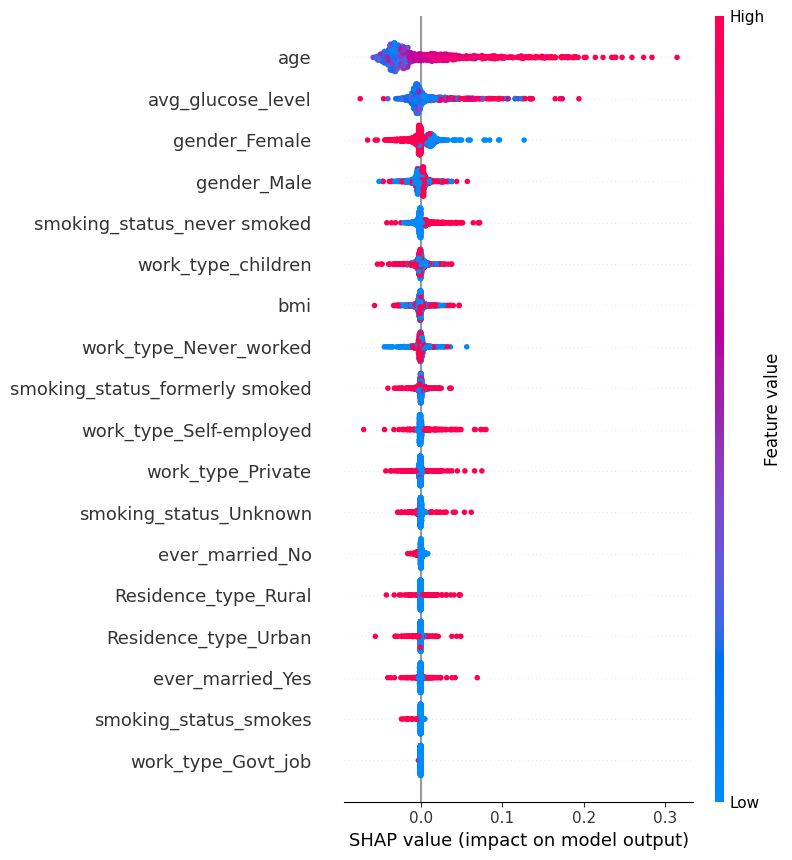

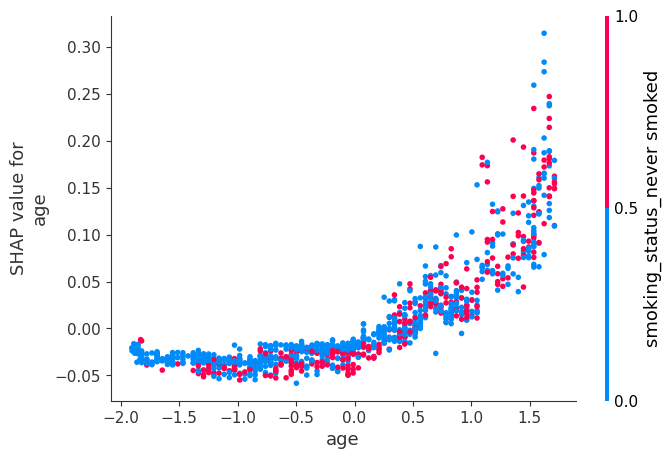

In [9]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_processed, y_train)

def predict_fn_rf(X):
    return rf_model.predict_proba(X)[:, 1]

background_kmeans = shap.kmeans(X_train_processed, 50)  # Create 50 clusters
explainer_rf = shap.KernelExplainer(predict_fn_rf, background_kmeans)

shap_values_rf = explainer_rf.shap_values(X_test_processed)

processed_feature_names = [
    'age', 'avg_glucose_level', 'bmi', 'gender_Female', 'gender_Male', 
    'ever_married_No', 'ever_married_Yes', 'work_type_Govt_job', 
    'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 
    'work_type_children', 'Residence_type_Rural', 'Residence_type_Urban', 
    'smoking_status_Unknown', 'smoking_status_formerly smoked', 
    'smoking_status_never smoked', 'smoking_status_smokes', 'stroke'
]

feature_names = processed_feature_names
shap.summary_plot(shap_values_rf, X_test_processed, feature_names=feature_names)
# PDP Plot
shap.dependence_plot('age', shap_values_rf, X_test_processed, feature_names=feature_names)